# CV Calculation

In [19]:
import sys

DATASET_PATH = ('../../../feedback-prize-2021')

sys.path.insert(0, '../codes/new_transformers_branch/transformers/src')
sys.path.append('../codes')
sys.path.append('..')

In [65]:
import os
import os.path as osp

import re
import pickle
import random
import easydict

from glob import glob
from tqdm.auto import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from new_transformers import DebertaV2TokenizerFast

import torch
from torch.nn import functional as F

torch.autograd.set_grad_enabled(False)

In [4]:
from module.metric import calc_acc, process_sample, make_match_dict

from module.utils import get_data_files
from module.dataset import get_dataloader
from module.loss import get_criterion
from module.optimizer import get_optimizer
from module.scheduler import get_scheduler
from model.model import get_model

In [58]:
args = easydict.EasyDict({'model': 'microsoft/deberta-v3-large-ducky',
                          'grad_checkpt': True,
                          'cnn1d': False,
                          'extra_dense': False,
                          'device': 0,
                          'ddp': False})

In [195]:
model = get_model(args)


Using Ducky Modified DebertaV2



Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.bias', 'mask_predictions.dense.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.weight', 'mask_predictions.classifier.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
osp.join(DATASET_PATH, '1')

'../../feedback-prize-2021/1'

In [21]:
fix_text = lambda x: x.replace('\n', '‽')

## Dataset

In [61]:
class ValDataset(torch.utils.data.Dataset):
    def __init__(self, files):
        tokenizer = DebertaV2TokenizerFast.from_pretrained('microsoft/deberta-v3-large')
        tokenizer.model_max_length = 2048
        self.tokenizer = tokenizer
        
        self.texts = {}
        self.raw_texts = {}
        
        for file in files:
            file_name = osp.join(DATASET_PATH, 'train', file + '.txt')
            with open(file_name) as f:
                text = f.read().strip()
                self.texts[file] = fix_text(text)
                self.raw_texts[file] = text
                
        self.text_ids = list(self.texts.keys())
        self.space_regex = re.compile('[\s\n]')
        
    def __len__(self):
        return len(self.text_ids)
    
    def __getitem__(self, ix):
        tokens_array = np.zeros(2048, 'i8')
        mask_array = np.zeros(2048, 'f4')
        offsets_array = np.zeros((2048, 2), 'i4')
        
        text = self.texts[self.text_ids[ix]]
        raw_text = self.raw_texts[self.text_ids[ix]]
        text_id = self.text_ids[ix]
        
        tokenizer_outs = self.tokenizer(text, return_offsets_mapping=True)
        tokenizer_outs['input_ids'] = [x if x != 126861 else 128000 for x in tokenizer_outs['input_ids']]
        
        tokens = np.array(tokenizer_outs['input_ids'], 'i8')
        mask = np.array(tokenizer_outs['attention_mask'], 'f4')
        offsets = np.vstack(tokenizer_outs['offset_mapping']).astype('i4')
        
        tokens_array[:len(tokens)] = tokens
        tokens_array[len(tokens):] = 0
        mask_array[:len(tokens)] = mask
        mask_array[len(tokens):] = 0
        offsets_array[:len(tokens)] = offsets
        offsets_array[len(tokens):] = 0
        
        index_map = []
        current_word = 0
        blank = False
        for char_ix in range(raw_text.index(raw_text.strip()[0]), len(raw_text)):
            if self.space_regex.match(raw_text[char_ix]) is not None:
                blank = True
            elif blank:
                current_word += 1
                blank = False
            index_map.append(current_word)
        
        return tokens_array, mask_array, offsets_array, index_map, text_id, len(tokens)
    
def collate_fn(ins):
    max_len = (max(x[-1] for x in ins) + 7) // 8 * 8
    return tuple(torch.from_numpy(np.concatenate([ins[z][x][None, :max_len] for z in range(len(ins))])) 
                 for x in range(len(ins[0]) - 3)) \
                 + ([x[-3] for x in ins], [x[-2] for x in ins], np.array([x[-1] for x in ins]),)

In [237]:
tokenizer = DebertaV2TokenizerFast.from_pretrained('microsoft/deberta-v3-large')
tokenizer.model_max_length = 5

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [243]:
tokenizer_outs = tokenizer('and will I know whats going on', return_offsets_mapping=True)
tokenizer_outs

{'input_ids': [1, 263, 296, 273, 391, 339, 268, 446, 277, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'offset_mapping': [(0, 0), (0, 3), (3, 8), (8, 10), (10, 15), (15, 20), (20, 21), (21, 27), (27, 30), (0, 0)]}

In [244]:
tokenizer_outs = tokenizer('and will I know wzats going on', return_offsets_mapping=True)
tokenizer_outs

{'input_ids': [1, 263, 296, 273, 391, 2976, 6407, 297, 268, 446, 277, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'offset_mapping': [(0, 0), (0, 3), (3, 8), (8, 10), (10, 15), (15, 17), (17, 19), (19, 20), (20, 21), (21, 27), (27, 30), (0, 0)]}

In [250]:
tokenizer.decode(tokenizer_outs['input_ids'][-7:])

'wzats going on[SEP]'

In [252]:
a = np.zeros(5)
a[:5] = np.array([1, 263, 296, 273, 391, 2976, 6407, 297, 268, 446, 277, 2])
a

ValueError: could not broadcast input array from shape (12) into shape (5)

## Metric

In [258]:
START_WITH_I = True
LOOK_AHEAD = True

def extract_entities(ps, n, return_score=False):
    max_ps = ps.max(-1)
    
    ps = ps.argsort(-1)[...,::-1]
    # argmax
    cat_ps = ps[:, 0]
    # argmax2
    cat_ps2 = ps[:, 1]
    
    all_entities = {}
    new_entity = True
    current_cat = current_start = current_end = None
    
    # except for special tokens
    for ix in range(1, n - 1):

        # logic on new entity
        if new_entity:
            # Background - ignore
            if cat_ps[ix] == 0:
                pass

            # B-LABEL(1,3,5,7,...) - start entity
            elif cat_ps[ix] % 2 == 1:
                current_cat = (cat_ps[ix] + 1) // 2
                current_start = current_end = ix
                new_entity = False
                
                if current_cat in [6, 7]:
                    LOOK_AHEAD = False
                else:
                    LOOK_AHEAD = True

            # I-LABEL(2,4,6,8,...) - conditional start
            elif cat_ps[ix] % 2 == 0:
                if START_WITH_I:
                    # Condition: I-LABEL in argmax with B-LABEL in argmax2
                    if cat_ps[ix] == (cat_ps2[ix]+1):
                        current_cat = cat_ps[ix] // 2
                        current_start = current_end = ix
                        new_entity = False
                        
                        if current_cat in [6, 7]:
                            LOOK_AHEAD = False
                        else:
                            LOOK_AHEAD = True
        
        # logic on ongoing entity
        else:
            # Background - save current entity and init current
            if cat_ps[ix] == 0:
                if LOOK_AHEAD:
                    if (cat_ps[ix+1] == current_cat*2) and (cat_ps2[ix] == current_cat*2):
                        current_end = ix
                    else:
                        # update current
                        if current_cat not in all_entities:
                            all_entities[current_cat] = []
                        all_entities[current_cat].append((current_start, current_end))

                        # init current for new start
                        new_entity = True
                        current_cat = current_start = current_end = None
                
                else:
                    # update current
                    if current_cat not in all_entities:
                        all_entities[current_cat] = []
                    all_entities[current_cat].append((current_start, current_end))

                    # init current for new start
                    new_entity = True
                    current_cat = current_start = current_end = None

            # B-LABEL(1,3,5,7,...) - save current entity and start new
            elif cat_ps[ix] % 2 == 1:
                if cat_ps[ix] == (current_cat*2-1):
                    # update current
                    if current_cat not in all_entities:
                        all_entities[current_cat] = []
                    all_entities[current_cat].append((current_start, current_end))

                    # start new current
                    current_cat = (cat_ps[ix] + 1) // 2
                    current_start = current_end = ix
                    new_entity = False
                    
                    if current_cat in [6, 7]:
                        LOOK_AHEAD = False
                    else:
                        LOOK_AHEAD = True
                
                else:
                    if LOOK_AHEAD:
                        if (cat_ps[ix+1] == current_cat*2) and (cat_ps2[ix] == current_cat*2):
                            current_end = ix
                        else:
                            # update current
                            if current_cat not in all_entities:
                                all_entities[current_cat] = []
                            all_entities[current_cat].append((current_start, current_end))

                            # start new current
                            current_cat = (cat_ps[ix] + 1) // 2
                            current_start = current_end = ix
                            new_entity = False
                        
                            if current_cat in [6, 7]:
                                LOOK_AHEAD = False
                            else:
                                LOOK_AHEAD = True
                            
                    else:
                        # update current
                        if current_cat not in all_entities:
                            all_entities[current_cat] = []
                        all_entities[current_cat].append((current_start, current_end))

                        # start new current
                        current_cat = (cat_ps[ix] + 1) // 2
                        current_start = current_end = ix
                        new_entity = False
                        
                        if current_cat in [6, 7]:
                            LOOK_AHEAD = False
                        else:
                            LOOK_AHEAD = True
                
            # I-LABEL(2,4,6,8,...) - conditional continue
            elif cat_ps[ix] % 2 == 0:
                # B-LABEL0, I-LABEL0 - continue
                if cat_ps[ix] == current_cat*2:
                    current_end = ix
                # B-LBAEL0, I-LABEL1 - conditional finish current entity
                else:
                    if LOOK_AHEAD:
                        if (cat_ps[ix+1] == current_cat*2) and (cat_ps2[ix] == current_cat*2):
                            current_end = ix
                        else:
                            # update current
                            if current_cat not in all_entities:
                                all_entities[current_cat] = []
                            all_entities[current_cat].append((current_start, current_end))

                            # init current
                            new_entity = True
                            current_cat = current_start = current_end = None
                    else:
                        # update current
                        if current_cat not in all_entities:
                            all_entities[current_cat] = []
                        all_entities[current_cat].append((current_start, current_end))

                        # init current
                        new_entity = True
                        current_cat = current_start = current_end = None
    
    # last entity
    if not new_entity:
        # update current
        if current_cat not in all_entities:
            all_entities[current_cat] = []
        all_entities[current_cat].append((current_start, current_end))
    
    return all_entities

In [266]:
def filter_ps(all_entities, ps):
    
    len_filters = [5, 2, 15, 2, 8, 7, 7]
    score_filters = [0.55, 0.50, 0.55, 0.45, 0.50, 0.45, 0.50]
    
    for cat_ix, min_num_tokens, min_score in zip(range(1, 8), len_filters, score_filters):
        
        if cat_ix in all_entities:
            possible_entities = [entity for entity in all_entities[cat_ix] 
                                 if entity[1] - entity[0] + 1 >= min_num_tokens
                                 and calc_entity_score(entity, ps, cat_ix) * (entity[1] - entity[0])**.2 > min_score]
    
            if cat_ix in (1, 2, 5):
                if len(possible_entities) > 1:
                    max_score = -9999
                    for possible_entity in possible_entities:
                        entity_score = calc_entity_score(possible_entity, ps, cat_ix)
                        if entity_score > max_score:
                            max_score = entity_score
                            biggest_entity = possible_entity
                    possible_entities = [biggest_entity]
            
            all_entities[cat_ix] = possible_entities
    
    return all_entities.items()

In [260]:
def calc_entity_score(span, ps, c):
    s, e = span
    score = (ps[s, c * 2 - 1] + ps[s + 1 : e + 1, c * 2].sum()) / (e - s + 1)
    return score

In [261]:
def map_span_to_word_indices(span, index_map, bounds):
    return (index_map[bounds[span[0], 0]], index_map[bounds[span[1], 1] - 1])

## F1 Score

In [74]:
def calc_overlap2(set_pred, set_gt):
    """
    Calculates the overlap between prediction and
    ground truth and overlap percentages used for determining
    true positives.
    """
    # Length of each and intersection
    try:
        len_gt = len(set_gt)
        len_pred = len(set_pred)
        inter = len(set_gt & set_pred)
        overlap_1 = inter / len_gt
        overlap_2 = inter/ len_pred
        return (overlap_1, overlap_2)
    except:  # at least one of the input is NaN
        return (0, 0)

def score_feedback_comp_micro2(pred_df, gt_df, discourse_type):
    """
    A function that scores for the kaggle
        Student Writing Competition
        
    Uses the steps in the evaluation page here:
        https://www.kaggle.com/c/feedback-prize-2021/overview/evaluation
    """
    gt_df = gt_df.loc[gt_df['discourse_type'] == discourse_type, 
                      ['id', 'predictionstring']].reset_index(drop=True)
    pred_df = pred_df.loc[pred_df['class'] == discourse_type,
                      ['id', 'predictionstring']].reset_index(drop=True)
    pred_df['pred_id'] = pred_df.index
    gt_df['gt_id'] = gt_df.index
    pred_df['predictionstring'] = [set(pred.split(' ')) for pred in pred_df['predictionstring']]
    gt_df['predictionstring'] = [set(pred.split(' ')) for pred in gt_df['predictionstring']]
    
    # Step 1. all ground truths and predictions for a given class are compared.
    joined = pred_df.merge(gt_df,
                           left_on='id',
                           right_on='id',
                           how='outer',
                           suffixes=('_pred','_gt')
                          )
    overlaps = [calc_overlap2(*args) for args in zip(joined.predictionstring_pred, 
                                                     joined.predictionstring_gt)]
    
    # 2. If the overlap between the ground truth and prediction is >= 0.5, 
    # and the overlap between the prediction and the ground truth >= 0.5,
    # the prediction is a match and considered a true positive.
    # If multiple matches exist, the match with the highest pair of overlaps is taken.
    joined['potential_TP'] = [(overlap[0] >= 0.5 and overlap[1] >= 0.5) \
                              for overlap in overlaps]
    joined['max_overlap'] = [max(*overlap) for overlap in overlaps]
    joined_tp = joined.query('potential_TP').reset_index(drop=True)
    tp_pred_ids = joined_tp\
        .sort_values('max_overlap', ascending=False) \
        .groupby(['id','gt_id'])['pred_id'].first()

    # 3. Any unmatched ground truths are false negatives
    # and any unmatched predictions are false positives.
    fp_pred_ids = set(joined['pred_id'].unique()) - set(tp_pred_ids)

    matched_gt_ids = joined_tp['gt_id'].unique()
    unmatched_gt_ids = set(joined['gt_id'].unique()) -  set(matched_gt_ids)

    # Get numbers of each type
    TP = len(tp_pred_ids)
    FP = len(fp_pred_ids)
    FN = len(unmatched_gt_ids)
    #calc microf1
    my_f1_score = TP / (TP + 0.5*(FP+FN))
    return my_f1_score

def score_feedback_comp2(pred_df, gt_df, return_class_scores=False):
    class_scores = {}
    for discourse_type in gt_df.discourse_type.unique():
        class_score = score_feedback_comp_micro2(pred_df, gt_df, discourse_type)
        class_scores[discourse_type] = class_score
    f1 = np.mean([v for v in class_scores.values()])
    if return_class_scores:
        return f1, class_scores
    return f1

## CV Calculation

In [43]:
with open('../data_file/id_to_ix_map.pickle', 'rb') as f:
    id_to_ix_map = {x.split('/')[-1].split('.')[0]: y for x, y in pickle.load(f).items()}
with open('../data_file/data_splits.pickle', 'rb') as f:
    data_splits = pickle.load(f)

val_files_all = []
val_ids_all = []

seed = 0
for val_fold in range(5):
    val_files = data_splits[seed][250]['normed'][val_fold]
    val_ids = [id_to_ix_map[x] for x in val_files]
    
    val_files_all.append(val_files)
    val_ids_all.append(val_ids)

In [78]:
len(val_files)

3140

In [199]:
label_names = [
    "None",
    "Lead",
    "Position",
    "Evidence",
    "Claim",
    "Concluding Statement",
    "Counterclaim",
    "Rebuttal",
]

outs_f = []
bounds_f = []
token_nums_f = []
word_indices_f = []
sample_ids_f = []

cv_n = 1
checkpoints = [f"../result/debertav3_fold0_f10.7006.pth" for i in range(cv_n)]


for val_fold in range(cv_n):
    val_files = val_files_all[val_fold]
    dataset = ValDataset(val_files)
    dataloader = torch.utils.data.DataLoader(
        dataset, collate_fn=collate_fn, batch_size=1, num_workers=2, shuffle=False
    )

    model.eval().cuda()

    all_outs = np.zeros((len(val_files), 2048, 15), "f4")
    all_bounds = np.zeros((len(val_files), 2048, 2), "i4")
    all_token_nums = np.zeros(len(val_files), "i4")
    all_word_indices = []
    all_sample_ids = []

    model.load_state_dict(torch.load(checkpoints[val_fold]))
    ix = 0
    for batch in tqdm(dataloader, leave=False):
        tokens, mask, bounds, word_indices, sample_ids, num_tokens = batch
        batch_size, batch_len = tokens.shape[:2]
        outs = torch.softmax(model(tokens.cuda(), mask.cuda()), -1)

        all_outs[ix : ix + batch_size, :batch_len] += outs.cpu().numpy()
        all_bounds[ix : ix + batch_size, :batch_len] = bounds
        all_token_nums[ix : ix + batch_size] = num_tokens
        all_word_indices.extend(word_indices)
        all_sample_ids.extend(sample_ids)

        ix += batch_size

    outs_f.append(all_outs)
    bounds_f.append(all_bounds)
    token_nums_f.append(all_token_nums)
    word_indices_f += all_word_indices
    sample_ids_f += all_sample_ids

all_outs = np.concatenate(outs_f)
all_bounds = np.concatenate(bounds_f)
all_token_nums = np.concatenate(token_nums_f)
all_word_indices = word_indices_f
all_sample_ids = sample_ids_f

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/3140 [00:00<?, ?it/s]

In [200]:
all_texts = {}
for sample_id in all_sample_ids:
    file_name = os.path.join(DATASET_PATH, "train", sample_id + ".txt")
    with open(file_name) as f:
        all_texts[sample_id] = f.read().strip()

(array([538., 781., 756., 507., 269., 152.,  68.,  51.,  13.,   5.]),
 array([ 159. ,  287.7,  416.4,  545.1,  673.8,  802.5,  931.2, 1059.9,
        1188.6, 1317.3, 1446. ]),
 <BarContainer object of 10 artists>)

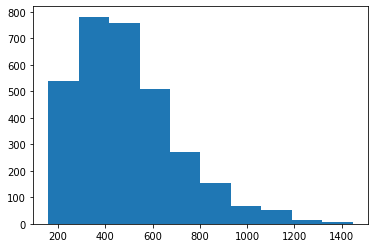

In [201]:
plt.hist(all_token_nums)

In [202]:
all_outs.shape

(3140, 2048, 15)

In [255]:
all_outs[0].argmax(-1)[:100]

array([6, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 0, 7, 8, 8, 8, 8, 8, 8])

In [256]:
all_token_nums[0]

642

In [264]:
filter_ps(
            extract_entities(all_outs[sample_ix], all_token_nums[sample_ix]),
            all_outs[sample_ix],
        )

dict_items([(1, []), (2, []), (4, []), (3, []), (6, []), (7, []), (5, [(557, 640)])])

In [269]:
sub_sample_ids = []
sub_cat_names = []
sub_spans = []
sub_scores = []

for sample_ix in tqdm(range(len(all_token_nums)), leave=False):
    predicted_spans = {
        x: {
            "entity": [
                map_span_to_word_indices(
                    span, all_word_indices[sample_ix], all_bounds[sample_ix]
                )
                for span in y
            ],
            "scores": [calc_entity_score(span, all_outs[sample_ix], x) for span in y],
        }
        for x, y in filter_ps(
            extract_entities(all_outs[sample_ix], all_token_nums[sample_ix]),
            all_outs[sample_ix],
        )
    }
    for cat_ix in predicted_spans:
        for entity in predicted_spans[cat_ix]["entity"]:
            sub_sample_ids.append(all_sample_ids[sample_ix])
            sub_cat_names.append(label_names[cat_ix])
            sub_spans.append(" ".join(str(x) for x in range(entity[0], entity[1] + 1)))

        for scores in predicted_spans[cat_ix]["scores"]:
            sub_scores.append(scores)

  0%|          | 0/3140 [00:00<?, ?it/s]

In [270]:
sub = pd.DataFrame(
    {
        "id": sub_sample_ids,
        "class": sub_cat_names,
        "predictionstring": sub_spans,
        "scores": sub_scores,
    }
)

In [271]:
sub

,id,class,predictionstring,scores
0,4BB5ADD5A1FE,Lead,3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20...,0.908804
1,4BB5ADD5A1FE,Position,22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 3...,0.921207
2,4BB5ADD5A1FE,Claim,40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 5...,0.395155
3,4BB5ADD5A1FE,Claim,58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73,0.839744
4,4BB5ADD5A1FE,Claim,74 75 76 77 78 79 80 81 82 83 84,0.895257
...,...,...,...,...
29619,D753B3C6BDDA,Evidence,18 19 20 21 22 23 24 25 26 27,0.464281
29620,D753B3C6BDDA,Evidence,101 102 103 104 105 106 107 108 109 110 111 11...,0.763377
29621,D753B3C6BDDA,Evidence,140 141 142 143 144 145 146 147 148 149 150 15...,0.726966
29622,D753B3C6BDDA,Evidence,433 434 435 436 437 438 439 440 441 442 443 44...,0.882594


In [272]:
val_fold_df = val_df.query('id in @sub.id.unique()').reset_index(drop=True)
val_fold_df

,id,discourse_type,predictionstring
0,48D3F4243F0F,Lead,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
1,48D3F4243F0F,Position,120 121 122 123 124 125 126 127 128 129 130 13...
2,48D3F4243F0F,Claim,154 155 156 157 158 159 160 161 162 163 164 16...
3,48D3F4243F0F,Evidence,174 175 176 177 178 179 180 181 182 183 184 18...
4,48D3F4243F0F,Claim,211 212 213 214 215 216 217 218 219 220 221 22...
...,...,...,...
29059,0814426B27DF,Claim,290 291 292 293 294 295 296 297 298 299 300 30...
29060,0814426B27DF,Evidence,315 316 317 318 319 320 321 322 323 324 325 32...
29061,0814426B27DF,Counterclaim,391 392 393 394 395 396 397 398
29062,0814426B27DF,Rebuttal,399 400 401 402 403 404 405 406 407 408 409 41...


In [273]:
val_fold_df = val_fold_df[["id", "discourse_type", "predictionstring"]].reset_index(drop=True)
val_fold_df.shape

(29064, 3)

In [274]:
print(score_feedback_comp2(sub, val_fold_df, return_class_scores=True))

(0.7009666655212109, {'Lead': 0.841688654353562, 'Position': 0.7271544715447155, 'Claim': 0.6623762858953732, 'Evidence': 0.7555579596473198, 'Counterclaim': 0.5732952225398121, 'Concluding Statement': 0.8640494365685205, 'Rebuttal': 0.4826446280991736})


In [75]:
sub = pd.DataFrame(
    {
        "id": sub_sample_ids,
        "class": sub_cat_names,
        "predictionstring": sub_spans,
        "scores": sub_scores,
    }
)

df = pd.read_csv(osp.join(DATASET_PATH, "train.csv"))

val_df = df[["id", "discourse_type", "predictionstring"]].reset_index(drop=True)
val_df.shape

print(score_feedback_comp2(sub, val_df, return_class_scores=True))

(0.08154630947334403, {'Lead': 0.08428175945862812, 'Position': 0.0, 'Evidence': 0.0, 'Claim': 0.0, 'Concluding Statement': 0.2920446830833796, 'Counterclaim': 0.050974512743628186, 'Rebuttal': 0.14352321102777216})


In [ ]:
STOP!!!

## Understanding the process

## Extract Entity

In [109]:
sample_ix = 241
out, token_n = all_outs[sample_ix], all_token_nums[sample_ix]

In [164]:
index_map, bounds = all_word_indices[sample_ix], all_bounds[sample_ix]

In [115]:
out.shape, token_n

((2048, 15), 437)

In [165]:
bounds

array([[0, 0],
       [0, 2],
       [2, 7],
       ...,
       [0, 0],
       [0, 0],
       [0, 0]], dtype=int32)

In [151]:
def extract_entities(preds, token_n):
    class_preds = preds.argmax(-1)
    all_entities = {}
    current_class = None
    current_start = None
    for ix in range(1, token_n - 1):
#         print('pred cat', class_preds[ix], 'current cat', current_class)
        if class_preds[ix] % 2 == 1:
            if current_class is not None:
                if current_class not in all_entities:
                    all_entities[current_class] = []
#                 print(f'added class {current_class}!')
                all_entities[current_class].append((current_start, ix - 1))
            current_class = (class_preds[ix] + 1) // 2
            current_start = ix        
        
    if current_class is not None:
        if current_class not in all_entities:
            all_entities[current_class] = []
        all_entities[current_class].append((current_start, ix))
    
    return all_entities

In [155]:
extract_out = extract_entities(out, token_n)
extract_out

{1: [(1, 24)],
 2: [(25, 33)],
 4: [(34, 116), (117, 131), (223, 231), (314, 326)],
 3: [(132, 142), (143, 222), (232, 313), (327, 386)],
 5: [(387, 435)]}

### map span

In [ ]:
def map_span_to_word_indices(span, index_map, bounds):
    return (index_map[bounds[span[0], 0]], index_map[bounds[span[1], 1] - 1])

In [169]:
span = (1, 24)

In [173]:
# first token's start index
# last tokens's end index
bounds[span[0], 0], bounds[span[1], 1] - 1

(0, 103)

In [176]:
# get the word index
index_map[bounds[span[0], 0]], index_map[bounds[span[1], 1] - 1]

(0, 19)

In [166]:
predicted_spans = {x: [map_span_to_word_indices(span, index_map, bounds) for span in y]
                   for x, y in extract_out.items()}

In [167]:
predicted_spans

{1: [(0, 19)],
 2: [(19, 26)],
 4: [(26, 97), (98, 107), (187, 192), (265, 277)],
 3: [(107, 117), (117, 186), (192, 264), (277, 328)],
 5: [(329, 375)]}

### function split_predstrig

In [132]:
def split_predstring(predstring):
    vals = predstring.split()
    return int(vals[0]), int(vals[-1])

In [134]:
split_predstring(val_df.predictionstring[0])

(1, 44)